In [1]:
from anti_qsweepy.drivers import *
from anti_qsweepy.routines import jpa_tuning
from matplotlib.pyplot import *
from numpy import *
from matplotlib import interactive
import time
import pickle
import datetime
interactive(True)
import scipy.optimize as so
import imp

In [2]:
imp.reload(jpa_tuning)

<module 'anti_qsweepy.routines.jpa_tuning' from 'C:\\simple_lab_scripts\\anti_qsweepy\\routines\\jpa_tuning.py'>

In [3]:
timestamp = lambda:datetime.datetime.fromtimestamp(time.time()).strftime('%d-%m_%H_%M_%S')

In [29]:
savepath = "E:\\Abramov\\2021-10-22\\tuning_tables"

In [5]:
pna = RS_ZNB20.NetworkAnalyzer('ZNB20')
pump = Agilent_PSG.Generator('Generator_E8257D')
bias = Keithley_6221.CurrentSource('GPIB2::10::INSTR')

# Manual 

In [3]:
pna.get_all()

{'nop': 500,
 'power': 10.0,
 'start freq': 10000000.0,
 'stop freq': 20000000000.0,
 'span': 19990000000.0,
 'bw': 1000.0,
 'sweep mode': 'LIN\n'}

In [182]:
pna.set_xlim(7e9, 8.5e9)

In [ ]:
pna.set_centerfreq(13.6e9/2)

In [179]:
pna.set_frequency(7.75e9+1e6)

True

In [55]:
pna.set_sweep_mode('lin')

True

In [4]:
pna.set_nop(20000)

True

In [5]:
pna.set_bandwidth(100)

True

In [7]:
pna.set_power(5)

True

In [6]:
pump.get_all()

{'status': True, 'freq': 14370000000.0, 'power': 1.1}

In [17]:
pump.set_status(1)

True

In [ ]:
pump.set_frequency(7.625e9*2)

In [409]:
pump.set_power(7.15)

True

In [350]:
pump.set_phase(-1.5)

True

In [18]:
print("Output:",bias.get_status())
print("Current:",bias.get_current())
print("Range:",bias.get_range())

Output: 1
Current: 0.001731
Range: 0.01


In [341]:
bias.set_range(100e-3)

True

In [6]:
bias.set_status(0)

True

In [343]:
bias.set_current(-0.7e-3 )

True

In [53]:
op = tt.ind(12)
tuner.set_op(op)

In [16]:
pna.post_sweep()

In [54]:
op.Fp

14800000000.0

# Network analyzer snapshot

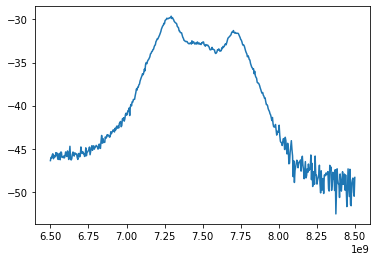

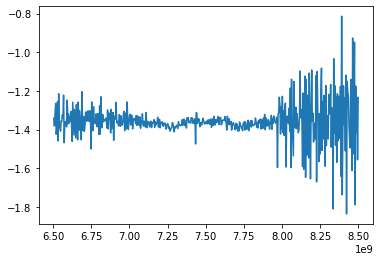

In [15]:
save_data = False
pna.set_sweep_mode('lin')
F = pna.get_freqpoints()
pna.pre_sweep()
data = pna.get_tracedata(format = 'REALIMAG')
S21 = data[0]+1.j*data[1]
figure("mag")
plot(F, 20*log10(abs(S21)))
figure("delay")
plot(F[1:], diff( unwrap(angle(S21)) ) )
if save_data:
    filename = "S21vsF"
    ts = timestamp()
    full_path = savepath+"\\"+ts+"_"+filename
    savefig(full_path+".png", dpi = 300)
    f = open(full_path+".pkl", 'wb')
    pickle.dump({'S21':S21, 'F':F, "Power":pna.get_power(), "Bandwidth":pna.get_bandwidth()} , f)
    f.close()
#xlim((6.95e9,7.05e9))

In [ ]:
S21_ref = S21

# Network analyzer CW snapshot

In [59]:
f_cw = 7.25e9-2e6
filename = 'snr'

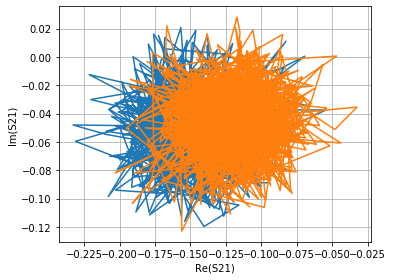

In [81]:
pump.set_status(1)
pna.set_sweep_mode('cw')
pna.set_frequency(f_cw)
pna.set_nop(1000)
pna.set_bandwidth(100e3)
pna.pre_sweep()
data = pna.get_tracedata(format = 'REALIMAG')
swe_time = pna.get_sweep_time()
S21_on = data[0]+1.j*data[1]
plot(S21_on.real, S21_on.imag)
pump.set_status(0)
time.sleep(0.1)
data = pna.get_tracedata(format = 'REALIMAG')
pna.post_sweep()
S21_off = data[0]+1.j*data[1]
plot(S21_off.real, S21_off.imag)
grid()
gca().set_aspect('equal')
pump.set_status(1)
xlabel("Re(S21)")
ylabel("Im(S21)")
tight_layout()
ts = timestamp()
full_path = savepath+"\\"+ts+"_"+filename
savefig(full_path+".png", dpi = 300)
f = open(full_path+".pkl", 'wb')
pickle.dump({'S21_on':S21_on, 'S21_on':S21_off, "time": swe_time, "Power":pna.get_power(), "Bandwidth":pna.get_bandwidth()} , f)
f.close()

In [82]:
snr_off= abs(mean(S21_off))/std(S21_off) 
snr_on = abs(mean(S21_on))/std(S21_on) 
snr_on/snr_off

1.1954629344624295

In [ ]:
f = open(savepath+'\\7GHz_S21.pkl', 'wb')
pickle.dump({'S21_on':S21_on, 'S21_on':S21_off, "time": swe_time, "Power":pna.get_power(), "Bandwidth":pna.get_bandwidth()} , f)
f.close()

In [ ]:
mean(20*log10(abs(S21_on)))

# S21 pump phase dependavce

In [ ]:
save_data =False
phases = linspace(-pi,pi,200)
pna.set_sweep_mode('cw')
pna.set_frequency(f_cw)
pna.set_nop(1)
pna.set_bandwidth(100)

S21 = array([],dtype = complex)
for ph in phases:
    pump.set_phase(ph)
    data = pna.get_tracedata(format = 'REALIMAG')
    S21 = hstack([S21,data[0]+1.j*data[1]])
plot(phases, 20*log10(abs(S21)))
if save_data:
    filename = "S21vsPhase"
    ts = timestamp()
    full_path = savepath+"\\"+ts+"_"+filename
    savefig(full_path+".png", dpi = 300)
    f = open(full_path+".pkl", 'wb')
    pickle.dump({'S21':S21, "Phase":phases ,'F':f_cw, "Power":pna.get_power(), "Bandwidth":pna.get_bandwidth()} , f)
    f.close()

# Gain compression

In [ ]:
detuning = 1e6
pna.set_sweep_mode('cw')
pna.set_frequency(f_cw+detuning )
pna.set_nop(1)
pna.set_bandwidth(100)

powers = arange(-70,-5,1)
ref_p = -50
ref_bw = 100
min_bw= 1

def set_power(p):
    pna.set_power(p)
    bw = 10**((p - ref_p)/10)*ref_bw 
    if bw<min_bw:
        bw = min_bw
    pna.set_bandwidth( bw ) 
    time.sleep(0.1)
result = sweeper.sweep(pna, (powers, set_power, 'Power'), measurement_type = "gain_compression")

In [ ]:
plot(result.datasets['S-parameter'].parameters[0].values, 20*log10(abs(result.datasets['S-parameter'].data)))


## Gain compression with tuning table

In [2]:
tt = jpa_tuning.TuningTable()
tt.load(savepath+"\\TuningTables\\20db.txt")

NameError: name 'jpa_tuning' is not defined

In [429]:
detuning = 1e6
pna.set_sweep_mode('cw')
pna.set_nop(1)
pna.set_bandwidth(100)

pump.set_status(1)
bias.set_status(1)

powers = arange(-70,1,1)
point_ind = range(len(tt.I))
ref_p = -50
ref_bw = 100
min_bw= 1

def set_power(p):
    if p == powers[-1]:
        pna.set_power(-30)
        pna.set_bandwidth( 100 )
        pump.set_status(0)
        time.sleep(0.05)
    else:    
        pna.set_power(p)
        bw = 10**((p - ref_p)/10)*ref_bw 
        if bw<min_bw:
            bw = min_bw
        pna.set_bandwidth( bw ) 
        time.sleep(0.1)

def set_op(i):
    op = tt.ind(i)
    bias.set_current(op.I)
    pna.set_frequency(op.Fp/2.+detuning)
    pump.set_frequency(op.Fp)
    pump.set_power(op.Pp)
    pump.set_status(1)
    time.sleep(0.05)
    
result = sweeper.sweep(pna, (point_ind, set_op, 'Operating point'), (powers, set_power, 'Power'), 
                       measurement_type = "gain_compression",
                      metadata = tt.to_dict() )

S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-pa

S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-pa

S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
load time:  0.05096912384033203
pre_trace_time:  0.0019979476928710938
trace 0 time:  0.030980348587036133
trace 1 time:  0.06396055221557617
trace 2 time:  0.09494209289550781
trace 3 time:  0.12992072105407715


In [ ]:
op = tt.ind(4)
tuner.set_op(op)

pna.set_sweep_mode('lin')
pna.set_centerfreq( op.Fp/2 )
pna.set_nop(600)
pna.set_bandwidth(1000)

pump.set_status(1)
powers = arange(-70,-5,1)
ref_p = -50
ref_bw = 1000
min_bw= 1

def set_power(p):
    pna.set_power(p)
    bw = 10**((p - ref_p)/10)*ref_bw 
    if bw<min_bw:
        bw = min_bw
    pna.set_bandwidth( bw ) 
    time.sleep(0.1)
result = sweeper.sweep(pna, (powers, set_power, 'Power'), measurement_type = "gain_compression",
                      metadata = {'G':op.G,'Fp':op.Fp, 'Pp':op.Pp,'I':op.I} )

# Resonator mapping

In [353]:
currents = arange(-7,7.05,0.05)*1e-3
result = sweeper.sweep(pna, (currents, bias.set_current, 'Current'), measurement_type = "resonator_mapping")

S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-pa

# Tuning

In [6]:
imp.reload(jpa_tuning)

<module 'anti_qsweepy.routines.jpa_tuning' from 'C:\\simple_lab_scripts\\anti_qsweepy\\routines\\jpa_tuning.py'>

In [7]:
tuner = jpa_tuning.JpaTuner(vna = pna, pump = pump, bias = bias)

In [32]:
tuner.I0 = 2e-3
tuner.I05 = 3.4e-3
tuner.dIraw = 0.1e-3
tuner.dIfine = 0.001e-3
tuner.Pp_init = -17
tuner.dPp_raw = 0.5
tuner.Ps = -30.
tuner.Pp_max = 18.
tuner.Gthr = 10.
tuner.df = 2e6

In [41]:
tuner.I0 = 2.75e-3
tuner.I05 = 4.08e-3
tuner.dIraw = 0.1e-3
tuner.dIfine = 0.001e-3
tuner.Pp_init = -17
tuner.dPp_raw = 0.5
tuner.Ps = -30.
tuner.Pp_max = 18.
tuner.Gthr = 10.
tuner.df = 2e6

In [34]:
op, status = tuner.find_gain_sm(20, 6e9)

Refrence measurement...
S21_ref = -49.36 dB
Raw search...
Raw search: P = -17.00 dBm I= 2.8000e-03A G = 20.87 dB
Noise measurement...
G = 9.28 Sigma= 6.550815e-02
Raw search: P = -17.00 dBm I= 2.8000e-03A G = 19.39 dB
Noise measurement...
G = 9.29 Sigma= 6.225710e-02
Max search: I= 2.8010e-03A G = 19.10 dB Gmax = 19.36 dB
Power optimization:P = -16.94 dBm G = 19.79 Gmax = 19.79
Itune I = 2.8040e-03A P = -16.94dBm G = 19.10dB
Itune I = 2.7660e-03A P = -17.12dBm G = 19.71dB


In [391]:
tt.add_point(op)

In [392]:
tt.dump(savepath+"\\20db.txt") 

In [45]:
target_gains = [20,]
for target_gain in target_gains:
    tt = jpa_tuning.TuningTable()
    for Fs in  arange(7.5e9, 8e9, 0.05e9) :
        print(Fs*1e-9)
        op,status = tuner.find_gain_sm(target_gain , Fs)
        #if status:
        tt.add_point(op)
        tt.dump(savepath+"\\{:.0f}db.txt".format(target_gain)) 

7.500000000000001
Refrence measurement...
S21_ref = -68.79 dB
Raw search...
Raw search: P = 1.50 dBm I= 3.2500e-03A G = 10.25 dBBB
Noise measurement...
G = 3.10 Sigma= 1.894229e-01
Max search: I= 3.2770e-03A G = 8.15 dB Gmax = 10.42 dBB
Power optimization:P = 4.89 dBm G = 16.36 Gmax = 18.43
Itune I = 3.2940e-03A P = 4.69dBm G = 16.79dB
Itune I = 3.2400e-03A P = 4.69dBm G = 17.11dB
Power optimization:P = 4.82 dBm G = 19.39 Gmax = 19.39
Itune I = 3.2960e-03A P = 4.82dBm G = 17.91dB
Itune I = 3.2590e-03A P = 4.82dBm G = 17.84dB
7.550000000000001
Refrence measurement...
S21_ref = -69.24 dB
Raw search...
Raw search: P = 0.50 dBm I= 3.4500e-03A G = 12.78 dBBB
Noise measurement...
G = 4.38 Sigma= 2.008164e-01
Max search: I= 3.4820e-03A G = 11.76 dB Gmax = 13.57 dB
Power optimization:P = 0.62 dBm G = 9.97 Gmax = 13.577
7.6000000000000005
Refrence measurement...
S21_ref = -69.31 dB
Raw search...
Raw search: P = 1.50 dBm I= 3.4500e-03A G = 11.34 dBBB
Noise measurement...
G = 3.46 Sigma= 1.980215

In [361]:
status

True

In [33]:
op,status = tuner.find_gain(20. , 6.9e9)

Refrence measurement...
S21_ref = 1.39 dB
Raw search...
I= -1.4300e-03A G = 20.45 dB
Noise measurement...
G = 10.64 Sigma= 1.380806e-01
Fine search...
I = -2.0370e-03A P = 13.34dBm G = 19.46dB


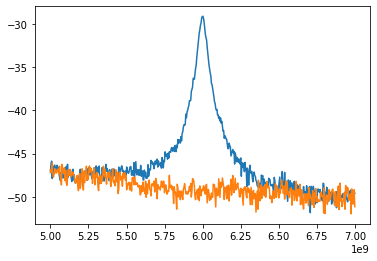

In [35]:
S21on, S21off, F  = tuner.vna_snapshot( op, 2e9, bw = 100,Ps = -40)
plot(F, 20*log10(abs(S21on)))
plot(F, 20*log10(abs(S21off)))

In [267]:
op.Pp = 13

## Save em all

In [9]:
tt = jpa_tuning.TuningTable()
tt.load(savepath+"\\20db.txt")

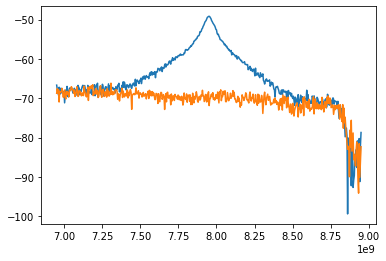

In [46]:
for i,op in enumerate(tt):
    S21on, S21off, F  = tuner.vna_snapshot( op, 2e9, bw = 50, Ps = -30)
    clf()
    plot(F, 20*log10(abs(S21on)))
    plot(F, 20*log10(abs(S21off)))
    
    filename = "{:d}".format(i)
    full_path = savepath+"\\20db\\"+filename
    
    savefig(full_path+".png", dpi = 300)
    
    f = open(full_path+".pkl", 'wb')
    pickle.dump({'S21on':S21on,'S21off':S21off,  'F':F, } , f)
    f.close()

In [ ]:
tt.dump(savepath+"\\table.txt")

In [ ]:
tt.load(savepath+"\\table.txt")

In [ ]:
tt.I

In [252]:
figure('test')
Plist = arange(12,13,1)
Ilist = arange(0.,-4.5e-3, -0.02e-3)
gain = zeros( [len(Plist), len(Ilist)] )
for i, P in enumerate(Plist):
    #pump.set_power(P)
    for j,I in enumerate(Ilist):
        bias.set_current(I)
        time.sleep(0.05)
        print('{:.2f} {:e}'.format(P,I), end = '\r')
        gain[i][j] = abs(tuner.meas_S21()[0])    

<Figure size 432x288 with 0 Axes>

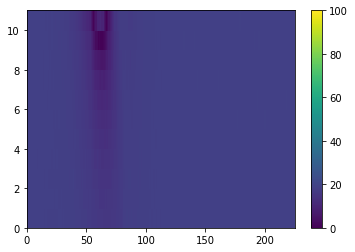

In [123]:
pcolormesh( sqrt((gain-20)**2) )
colorbar()
clim([0,100])

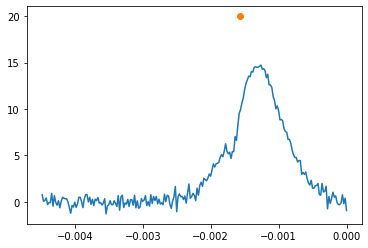

In [253]:
for g in gain:
    plot(Ilist,log10(g)*20)
    plot(op.I, 20,'o')

In [179]:
op.I

-0.002632000000000007

In [27]:
tt[1]

TypeError: 'TuningTable' object is not subscriptable